[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34//AsTFSONN/blob/main/model/AsTFSONN.ipynb)

### **Mount Colab**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install mat73
import mat73

### **Load Signal Data**

In [3]:
sig_dict=mat73.loadmat('/content/gdrive/MyDrive/Colab Notebooks/EDP/Data/Asthma_sig_part1.mat')
sig_dict2=mat73.loadmat('/content/gdrive/MyDrive/Colab Notebooks/EDP/Data/Asthma_sig_part2.mat')
healthy_dict = mat73.loadmat('/content/gdrive/MyDrive/Colab Notebooks/EDP/Data/Healthy_sig.mat')
print(sig_dict.keys())  # Check available variables
print(healthy_dict.keys())
print(sig_dict2.keys())


dict_keys(['Asthma_sig_part1'])
dict_keys(['Healthy_sig'])
dict_keys(['Asthma_sig_part2'])


In [4]:
X_asthma = sig_dict["Asthma_sig_part1"]
X_healthy = healthy_dict["Healthy_sig"]
X_asthma2 = sig_dict2["Asthma_sig_part2"]
print(X_asthma.shape, X_healthy.shape, X_asthma2.shape)  # Check shapes


(20000, 600) (20000, 534) (20000, 228)


In [5]:
X_asthma = X_asthma.T  # Shape becomes (600, 20000)
X_asthma2 = X_asthma2.T  # Shape becomes (228, 20000)
X_healthy = X_healthy.T  # Shape becomes (534, 20000)

print(X_asthma.shape, X_asthma2.shape, X_healthy.shape)  # Verify shapes


(600, 20000) (228, 20000) (534, 20000)


In [6]:
X_combined = np.vstack((X_asthma, X_asthma2, X_healthy))
print(X_combined.shape)  # Should be (total_rows, 20000)

(1362, 20000)


In [7]:
asthma_label = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/EDP/Data/Asthma_labels.xlsx', header=None)
healthy_label = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/EDP/Data/Healthy_labels.xlsx', header=None)
print(asthma_label.shape, healthy_label.shape)  # Check shapes

(534, 1) (828, 1)


In [8]:
print(asthma_label.shape, healthy_label.shape)
Y_combined = np.vstack((asthma_label, healthy_label))
print(Y_combined.shape)  # Should be (1362, 1)

(534, 1) (828, 1)
(1362, 1)


In [9]:
sig=X_combined
sig.shape

(1362, 20000)

### **Labels**

In [10]:
# labels=pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/EDP/Data/Asthma_labels.xlsx',header=None)
labels = Y_combined
l=np.array(labels)
label_list=[]
for i in range (1362):
  if l[i]=='Asthma':
    label_list.append(0)
  else:
    label_list.append(1)
Y=np.array(label_list)
Y.shape


(1362,)

### **Create Melspectrogram and Convert Them To 1-channel RGB Image**

In [11]:
import librosa
r=len(sig[:,1])
nfft=1024
win_length=1024
hop_length=410;sr=4000
audio_rgb_list=[]
d_shape=64

import cv2 as cvlib
for i in range (r):
  clip=sig[i,:]
  mel_spec=librosa.feature.melspectrogram( y=clip, sr=4000,n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann')
  log_spectrogram = librosa.amplitude_to_db(mel_spec)
  norm=(log_spectrogram-np.min(log_spectrogram))/(np.max(log_spectrogram)-np.min(log_spectrogram))
  img = norm
  img=cvlib.resize(img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
  audio_rgb_list.append(img)

X=np.array(audio_rgb_list)
print('shape of prev spectrogram dataset'+str(np.shape(X)))
X=np.reshape(X,(1362,1,64,64))
print('shape of one spectrogram dataset'+str(np.shape(X)))

shape of prev spectrogram dataset(1362, 64, 64)
shape of one spectrogram dataset(1362, 1, 64, 64)


### **Create the Neural Network**

In [12]:
!git clone https://github.com/junaidmalik09/fastonn.git
%cd /content/fastonn
!pip install .
import fastonn
from fastonn import SelfONN2d

fatal: destination path 'fastonn' already exists and is not an empty directory.
/content/fastonn
Processing /content/fastonn
  Preparing metadata (setup.py) ... done
  Created wheel for fastonn: filename=fastonn-0.1.1-py3-none-any.whl size=299623 sha256=116ae85c5119043f52d5f207a77735cb8e570870b129fc01878379f512abff3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ndma_77p/wheels/1b/fb/0b/411fe15828f088e3036fc0f5f1fb6f7ed8f2eb6e7966a54199
Successfully built fastonn
  Attempting uninstall: fastonn
    Found existing installation: fastonn 0.1.1
    Uninstalling fastonn-0.1.1:
      Successfully uninstalled fastonn-0.1.1


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [14]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

187

In [16]:
from sklearn.model_selection import train_test_split
def create_datasets(X, y, test_size=0.15,seed=None):
    X_train1, X_test, y_train1, y_test = train_test_split(X, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.1,random_state=seed)
    X_train, X_valid, X_test = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid, X_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    test_ds= TensorDataset(X_test, y_test)
    return train_ds, valid_ds, test_ds


In [17]:
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

In [18]:
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(X,Y,seed=25)

Preparing datasets
(137,)


In [19]:
bs = 128
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Creating data loaders with batch size: 128


In [20]:
from torch import nn
from torchsummary import summary
from torch.nn import Conv2d

class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 3 conv blocks / flatten / linear / softmax
        self.onnv1 = nn.Sequential(
            SelfONN2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                q=3
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
             SelfONN2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                q=3
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv3 = nn.Sequential(
            SelfONN2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3,
                q=3
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32*6*6, 500)#
        self.relu=nn.ELU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(500, 2)
        self.output_l = nn.Softmax()

    def forward(self, input_data):
        x = self.onnv1(input_data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x= self.dropout(x)
        logits = self.linear2(x)
        predictions = self.output_l(logits)
        return x#logits

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 62]             448
              Tanh-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
         SelfONN2d-4           [-1, 32, 29, 29]          13,856
              Tanh-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
         SelfONN2d-7           [-1, 32, 12, 12]          27,680
              Tanh-8           [-1, 32, 12, 12]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
          Flatten-10                 [-1, 1152]               0
           Linear-11                  [-1, 500]         576,500
          Dropout-12                  [-1, 500]               0
          Dropout-13                  [-1, 500]               0
           Linear-14                   

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1845: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


### **Train Model_2**

In [21]:
lr = 0.001
n_epochs = 252
iterations_per_epoch = len(trn_dl)
num_classes = 2
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
trainloss_history = []
valacc_history = []
valloss_history = []
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):

    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    trainloss_history.append(loss)

    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for x_val, y_val in val_dl:
            x_val, y_val = [t.cuda() for t in (x_val, y_val)]
            out = model(x_val)
            valid_loss = criterion(out, y_val)
            preds = F.log_softmax(out, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Validation Acc.: {valid_acc:2.2%}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Start model training
Epoch:   1. Training Loss: 3.7377. Validation Loss: 0.8164. Validation Acc.: 63.41%
Epoch:   2. Training Loss: 2.9242. Validation Loss: 1.2242. Validation Acc.: 61.79%
Epoch:   3. Training Loss: 3.5153. Validation Loss: 0.7717. Validation Acc.: 60.98%
Epoch:   4. Training Loss: 3.1664. Validation Loss: 0.8875. Validation Acc.: 60.98%
Epoch:   5. Training Loss: 3.0625. Validation Loss: 0.8050. Validation Acc.: 63.41%
Epoch:   6. Training Loss: 3.6363. Validation Loss: 0.8229. Validation Acc.: 60.16%
Epoch:   7. Training Loss: 3.0437. Validation Loss: 0.8146. Validation Acc.: 63.41%
Epoch:   8. Training Loss: 4.0467. Validation Loss: 0.8485. Validation Acc.: 59.35%
Epoch:   9. Training Loss: 3.4610. Validation Loss: 0.7961. Validation Acc.: 63.41%
Epoch:  10. Training Loss: 4.1097. Validation Loss: 0.7863. Validation Acc.: 63.41%
Epoch:  11. Training Loss: 3.0359. Validation Loss: 0.7956. Validation Acc.: 65.04%
Epoch:  12. Training Loss: 3.1243. Validation Loss: 0.7

### **Test the Model**

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


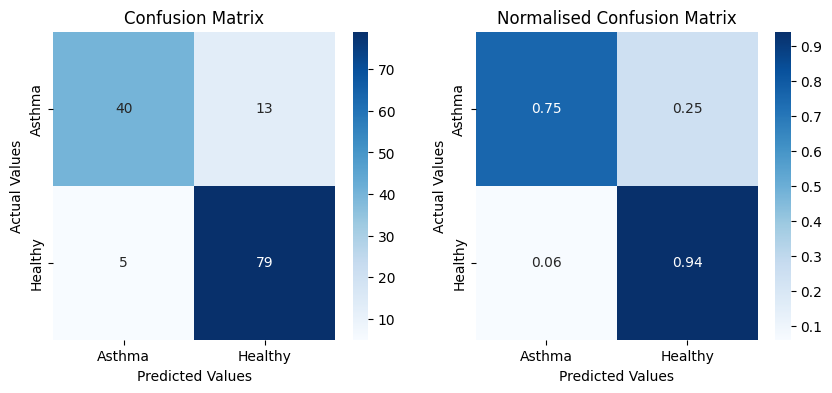

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

model.eval()
for x_tst, y_tst in tst_dl:
    xtst_batches = x_tst.cuda()#[t.to(device) for t in (x_tst)]
    out = model(xtst_batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [23]:
import torch

# Assuming your model variable is called 'model'
torch.save(model.state_dict(), "asthma_model.pth")


In [24]:
import os
print(os.getcwd())


/content/fastonn


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
    from sklearn.metrics import confusion_matrix
    import sklearn
    cm=confusion_matrix(y_true,y_pred)
    print('Confusion Matrix');
    print(cm)
    precision = sklearn.metrics.precision_score(y_true,y_pred)
    print('precision==   '+str(precision))
    accuracy=np.diag(cm).sum()/cm.sum().sum()
    print('Accuracy==    '+str(accuracy))
    recall = sklearn.metrics.recall_score(y_true,y_pred)
    print('Recall==      '+str(recall))
    F1 = sklearn.metrics.f1_score(y_true,y_pred)
    print('F1-Score==    '+str(F1))
    K_cappa = sklearn.metrics.cohen_kappa_score(y_true,y_pred)
    print('Kcappa==      '+str(K_cappa))

Confusion Matrix
[[40 13]
 [ 5 79]]
precision==   0.8586956521739131
Accuracy==    0.8686131386861314
Recall==      0.9404761904761905
F1-Score==    0.8977272727272727
Kcappa==      0.7151109057301295


In [27]:
!install torch

install: missing destination file operand after 'torch'
Try 'install --help' for more information.


In [29]:
# Install dependencies
!pip install fastonn librosa opencv-python --quiet

# Imports
import torch
import torch.nn as nn
import librosa
import numpy as np
import cv2 as cvlib
from fastonn import SelfONN2d

# Define the exact trained model class
class ONNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.onnv1 = nn.Sequential(
            SelfONN2d(1, 16, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(16, 32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.onnv3 = nn.Sequential(
            SelfONN2d(32, 32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32*6*6, 500)
        self.dropout = nn.Dropout(0.3)
        self.linear2 = nn.Linear(500, 2)
        self.output_l = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.onnv1(input_data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.dropout(x)
        logits = self.linear2(x)
        predictions = self.output_l(logits)
        return logits  # logits because you did that during training

# Load model
import torch
from torch.serialization import add_safe_globals

# Add ONNNetwork to safe globals to allow unpickling
add_safe_globals({'ONNNetwork': ONNNetwork})

# Load the full model
model = torch.load('/content/trained_model.pt', map_location=torch.device('cpu'))
model.eval()


# Preprocess audio file into melspectrogram tensor
# def preprocess_audio(file_path):
#     clip, sr = librosa.load(file_path, sr=4000)
#     mel_spec = librosa.feature.melspectrogram(y=clip, sr=4000, n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann')
#     log_spectrogram = librosa.amplitude_to_db(mel_spec)
#     norm_spec = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
#     img = cvlib.resize(norm_spec, dsize=(64, 64), interpolation=cvlib.INTER_CUBIC)
#     tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 64, 64]
#     return tensor

import librosa
import numpy as np
from scipy.fft import fft, ifft
import cv2 as cvlib

def preprocess_and_extract_mel(file_path, frame_length_sec=5, overlap=0.5, baseline_cutoff=0.5,
                               sr=4000, n_fft=1024, win_length=1024, hop_length=410, n_mels=64, d_shape=64):
    # Load audio
    signal, sr_actual = librosa.load(file_path, sr=sr)

    # Calculate frame and hop lengths in samples
    frame_length_samples = int(frame_length_sec * sr)
    hop_length_samples = int(frame_length_samples * (1 - overlap))

    # Framing
    frames = librosa.util.frame(signal, frame_length=frame_length_samples, hop_length=hop_length_samples).T

    def remove_baseline_wander(frame, sr, cutoff=baseline_cutoff):
        N = len(frame)
        freqs = np.fft.fftfreq(N, d=1/sr)
        fft_vals = fft(frame)
        fft_vals[np.abs(freqs) < cutoff] = 0  # Remove low-frequency components
        clean_frame = np.real(ifft(fft_vals))
        return clean_frame

    # Baseline wander removal
    clean_frames = np.array([remove_baseline_wander(f, sr) for f in frames])

    # Normalization (Z-score)
    normalized_frames = (clean_frames - np.mean(clean_frames, axis=1, keepdims=True)) / np.std(clean_frames, axis=1, keepdims=True)

    # Mel-spectrogram extraction and resizing
    audio_rgb_list = []
    for clip in normalized_frames:
        mel_spec = librosa.feature.melspectrogram(y=clip, sr=sr, n_fft=n_fft, win_length=win_length,
                                                  hop_length=hop_length, n_mels=n_mels, window='hann')
        log_spectrogram = librosa.amplitude_to_db(mel_spec)
        norm = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
        img = cvlib.resize(norm, dsize=(d_shape, d_shape), interpolation=cvlib.INTER_CUBIC)
        audio_rgb_list.append(img)

    return np.array(audio_rgb_list), sr

# Example usage:
file_path = 'lung_sound.wav'
mel_spectrogram_images, sr = preprocess_and_extract_mel(file_path)
print(mel_spectrogram_images.shape)  # (num_frames, 64, 64)

# Prediction function
def predict(file_path):
    # Preprocess
    mel_spectrogram_images, _ = preprocess_and_extract_mel(file_path)

    # Reshape and convert to tensor
    X = mel_spectrogram_images.reshape((-1, 1, 64, 64))
    X_tensor = torch.tensor(X, dtype=torch.float32)

    predictions = []
    with torch.no_grad():
        for frame in X_tensor:
            frame = frame.unsqueeze(0)  # Add batch dimension [1, 1, 64, 64]
            output = model(frame)
            predicted_class = torch.argmax(output, dim=1).item()
            predictions.append(predicted_class)

    # Optionally: Majority vote (since each frame gives one prediction)
    final_prediction = max(set(predictions), key=predictions.count)

    return 'Asthma' if final_prediction == 0 else 'Normal'

# Predict on your audio file
file_path = '/content/BP73_N,N,P L L,32,M.wav'
result = predict(file_path)
print(f"Prediction for: {result}")


AttributeError: 'str' object has no attribute '__module__'

In [ ]:
# Install dependencies (for Colab)
# !pip install librosa torch numpy opencv-python

import torch
from torch import nn
import librosa
import numpy as np
import cv2 as cvlib

# Dummy SelfONN2d implementation as a placeholder
class SelfONN2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, q=3, stride=1, padding=1):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

# Define the ONN-based CNN model
class ONNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.onnv1 = nn.Sequential(
            SelfONN2d(1, 16, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(16, 32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.onnv3 = nn.Sequential(
            SelfONN2d(32, 32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32*6*6, 500)
        self.dropout = nn.Dropout(0.3)
        self.linear2 = nn.Linear(500, 2)
        self.output_l = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.onnv1(input_data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.dropout(x)
        logits = self.linear2(x)
        predictions = self.output_l(logits)
        return predictions

# Load trained model
model = ONNNetwork()
model.load_state_dict(torch.load("/content/asthma_model.pth", map_location=torch.device('cpu')))
model.eval()

# Audio preprocessing and mel-spectrogram conversion
def preprocess_audio(file_path):
    clip, sr = librosa.load(file_path, sr=4000)
    mel_spec = librosa.feature.melspectrogram(
        y=clip, sr=4000, n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann'
    )
    log_spectrogram = librosa.amplitude_to_db(mel_spec)
    norm_spec = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
    img = cvlib.resize(norm_spec, dsize=(64, 64), interpolation=cvlib.INTER_CUBIC)
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return tensor

# Predict function: returns class label
def predict(file_path, model):
    tensor = preprocess_audio(file_path)
    with torch.no_grad():
        output = model(tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_label = 'Asthma' if predicted_class == 0 else 'Normal'
    return predicted_label

# Predict probabilities
def predict_proba(file_path, model):
    tensor = preprocess_audio(file_path)
    with torch.no_grad():
        output = model(tensor)
        probs = output.numpy()[0]
    return {'Asthma': probs[0], 'Normal': probs[1]}

# Example usage
file_path = "/content/BP86_N,N,P R U,68,F.wav"
print("Predicted Class:", predict(file_path, model))
print("Prediction Probabilities:", predict_proba(file_path, model))


In [ ]:
# Install dependencies (for Colab)
# !pip install librosa torch numpy opencv-python

import torch
from torch import nn
import librosa
import numpy as np
import cv2 as cvlib

# Dummy SelfONN2d implementation as a placeholder
class SelfONN2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, q=3, stride=1, padding=1):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

# Define ONNNetwork matching saved model (3 input channels)
class ONNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.onnv1 = nn.Sequential(
            SelfONN2d(3, 16, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(16, 32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.onnv3 = nn.Sequential(
            SelfONN2d(32, 32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32*6*6, 500)
        self.dropout = nn.Dropout(0.3)
        self.linear2 = nn.Linear(500, 2)
        self.output_l = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.onnv1(input_data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.dropout(x)
        logits = self.linear2(x)
        predictions = self.output_l(logits)
        return predictions

# Load trained model
model = ONNNetwork()
model.load_state_dict(torch.load("/content/asthma_model.pth", map_location=torch.device('cpu')))
model.eval()

# Audio preprocessing and mel-spectrogram conversion to 3-channel
def preprocess_audio(file_path):
    clip, sr = librosa.load(file_path, sr=4000)
    mel_spec = librosa.feature.melspectrogram(
        y=clip, sr=4000, n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann'
    )
    log_spectrogram = librosa.amplitude_to_db(mel_spec)
    norm_spec = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
    img = cvlib.resize(norm_spec, dsize=(64, 64), interpolation=cvlib.INTER_CUBIC)
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(1, 3, 1, 1)
    return tensor

# Predict class label
def predict(file_path, model):
    tensor = preprocess_audio(file_path)
    with torch.no_grad():
        output = model(tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_label = 'Asthma' if predicted_class == 0 else 'Normal'
    return predicted_label

# Predict probability scores
def predict_proba(file_path, model):
    tensor = preprocess_audio(file_path)
    with torch.no_grad():
        output = model(tensor)
        probs = output.numpy()[0]
    return {'Asthma': probs[0], 'Normal': probs[1]}

# Example test
file_path = "/content/BP86_N,N,P R U,68,F.wav"
print("Predicted Class:", predict(file_path, model))
print("Prediction Probabilities:", predict_proba(file_path, model))


In [ ]:
import librosa
import numpy as np
import torch
from torch import nn
import cv2 as cv
from fastonn import SelfONN2d

# ========== Audio Preprocessing ==========

def preprocess_audio(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=4000)

    # Compute Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=4000, n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann'
    )

    # Convert to log scale (dB)
    log_spectrogram = librosa.amplitude_to_db(mel_spec)

    # Normalize to [0, 1]
    norm = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))

    # Resize to (64, 64)
    img = cv.resize(norm, dsize=(64, 64), interpolation=cv.INTER_CUBIC)

    # Convert to 3-channel RGB by stacking the grayscale image
    img_rgb = np.stack([img, img, img], axis=0)  # Shape: (3, 64, 64)

    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor(img_rgb, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 3, 64, 64)

    return input_tensor

# ========== ONN Network Definition ==========

class ONNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1, out_channels=16, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16, out_channels=32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32, out_channels=32, kernel_size=3, q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32 * 6 * 6, 500)
        self.dropout = nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(500, 2)
        self.output_l = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.onnv1(input_data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        logits = self.linear2(x)
        predictions = self.output_l(logits)
        return predictions

# ========== Load Model and Predict ==========

def predict_class(audio_path, model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Preprocess input audio
    input_tensor = preprocess_audio(audio_path).to(device)

    # Initialize model and load weights
    model = ONNNetwork().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    return "Asthma" if pred_class == 0 else "Healthy"

# ========== Run Prediction ==========

if __name__ == "__main__":
    audio_path = "/content/BP86_N,N,P R U,68,F.wav"
    model_path = "/content/asthma_model.pth"

    prediction = predict_class(audio_path, model_path)
    print(f"Predicted class: {prediction}")
